### Import

In [4]:
import pandas as pd
import numpy as np

import os
from tqdm import tqdm
import json
import shutil

# image data
from PIL import Image
from glob import glob
# import cv2

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [6]:
!nvidia-smi

Fri Oct  7 07:16:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   32C    P0    37W / 300W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   30C    P0    40W / 300W |      0MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

### 1. EDA

In [ ]:
os.getcwd()

In [ ]:
# define paths for ART, PRE train datas

ART_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/'
PRE_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/PRE/'

print("ART_TRAIN N: ", len(os.listdir(ART_path)))
print("PRE_TRAIN N: ", len(os.listdir(PRE_path)))

ART

In [ ]:
# 사람별 ct 이미지 장수 확인

LABEL_path = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/1.Training/라벨링데이터/'
people = os.listdir(LABEL_path)
n_list = []

for ppl in people: 
    lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/{}_*'.format(ppl))
    lst.sort()
    n_list.append(len(lst))
    print(ppl, "N: ", len(lst))

In [ ]:
n_list = pd.DataFrame(n_list)

In [ ]:
n_list[0].describe()

In [ ]:
# 0장인 사람이?
# 0drop후 describe

n_list = n_list.loc[n_list[0] != 0].reset_index(drop = True)
n_list[0].describe()

In [ ]:
lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing/Train_data/ART/02_01_0001_*')
lst.sort()
lst

In [ ]:
len(lst)

In [ ]:
import matplotlib.pyplot as plt

test1 = Image.open(lst[0])
test2 = Image.open(lst[2])

test = np.concatenate((test1, test2), axis = 1)

plt.imshow(test)

In [ ]:
# 02_01_0001 

for i in range(0, 100, 10): 
    plt.figure(figsize = (20, 20))
    test = Image.open(lst[i])
    for j in range(i + 1, i + 10): 
        tmp = Image.open(lst[j])
        test = np.concatenate((test, tmp), axis = 1)
    plt.imshow(test)
    print('{} - {}'.format(i, i+10))

In [ ]:
len(lst)

In [ ]:
test = Image.open(lst[100])
plt.figure(figsize = (10, 10))
for i in range(101, 106): 
    tmp = Image.open(lst[i])
    test = np.concatenate((test, tmp), axis = 1)
    plt.imshow(test)
    print('{} - {}'.format(100, 106))

In [ ]:
lst = glob('/home/ncp/workspace/blocks1/kidneyData_windowing/Train_data/ART/02_01_0003_*')
lst.sort()
lst

In [ ]:
len(lst)

In [ ]:
# 02_01_0003

for i in range(0, 80, 10): 
    plt.figure(figsize = (20, 20))
    test = Image.open(lst[i])
    for j in range(i + 1, i + 10): 
        tmp = Image.open(lst[j])
        test = np.concatenate((test, tmp), axis = 1)
    plt.imshow(test)
    print('{} - {}'.format(i, i+10))

In [ ]:
test = Image.open(lst[80])
plt.figure(figsize = (10, 10))
for i in range(81, 86): 
    tmp = Image.open(lst[i])
    test = np.concatenate((test, tmp), axis = 1)
    plt.imshow(test)
    print('{} - {}'.format(80, 86))

In [ ]:
# dcm header check
import pydicom

path__ = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/1.Training/원천데이터/02_01_0001/02_01_0001_ART/0001.dcm'
header_01 = pydicom.dcmread(path__, stop_before_pixels = True)
header_01

In [ ]:
# dcm header check
import pydicom

path__ = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/1.Training/원천데이터/02_01_0010/02_01_0010_ART/0001.dcm'
header_01 = pydicom.dcmread(path__, stop_before_pixels = True)
header_01

### 2. Create label 

In [ ]:
LABEL_path = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/1.Training/라벨링데이터/'
people = os.listdir(LABEL_path)

In [ ]:
ppl = people[0]
ppl_ARTlabel_path = LABEL_path + ppl + '/' + '{}_ART.json'.format(ppl)
with open(ppl_ARTlabel_path) as f: 
    ART_json = json.load(f)

In [ ]:
# 02_01_0001
ppl = '02_01_0001'
ppl_ARTlabel_path = LABEL_path + ppl + '/' + '02_01_0001_ART.json'.format(ppl)
with open(ppl_ARTlabel_path) as f: 
    ART_json = json.load(f)

In [ ]:
ART_json

In [ ]:
length = len(ART_json['roi_list']['left mass'])
z_list = []
for i in range(length): 
    z_list.append(ART_json['roi_list']['left mass'][i]['z'])

In [ ]:
# 02_01_0003
ppl = '02_01_0003'
ppl_ARTlabel_path = LABEL_path + ppl + '/' + '02_01_0003_ART.json'.format(ppl)
with open(ppl_ARTlabel_path) as f: 
    ART_json = json.load(f)

In [ ]:
ART_json

In [ ]:
# check z length

length = len(ART_json['roi_list']['right mass'])
z_list = []
for i in range(length): 
    z_list.append(ART_json['roi_list']['right mass'][i]['z'])

In [ ]:
z_list = set(z_list)
z_list

In [ ]:
length = len(ART_json['roi_list']['left kidney'])
z_list = []
for i in range(length): 
    z_list.append(ART_json['roi_list']['left kidney'][i]['z'])

In [ ]:
z_list = set(z_list)
z_list

In [7]:
# create ART_train_label dataframe

LABEL_path = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/1.Training/라벨링데이터/'
people = os.listdir(LABEL_path) 
ART_train_label = pd.DataFrame()

for ppl in tqdm(people): 
    ppl_ARTlabel_path = LABEL_path + ppl + '/' + '{}_ART.json'.format(ppl)
    with open(ppl_ARTlabel_path) as f: 
        ART_json = json.load(f)
    case_id = ART_json['case_id'][0:10]
    type = ART_json['Clinical Information (Global)']['histologic type']
    data = {'case_id' : [case_id], 'histologic type' : [type]}
    data = pd.DataFrame(data)
    ART_train_label = pd.concat([ART_train_label, data]).reset_index(drop = True)

100%|██████████| 320/320 [00:28<00:00, 11.04it/s]


In [8]:
# create ART_val_label dataframe

LABEL_path = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/2.Validation/라벨링데이터/'
people = os.listdir(LABEL_path) 
ART_val_label = pd.DataFrame()

for ppl in tqdm(people): 
    ppl_ARTlabel_path = LABEL_path + ppl + '/' + '{}_ART.json'.format(ppl)
    with open(ppl_ARTlabel_path) as f: 
        ART_json = json.load(f)
    case_id = ART_json['case_id'][0:10]
    type = ART_json['Clinical Information (Global)']['histologic type']
    data = {'case_id' : [case_id], 'histologic type' : [type]}
    data = pd.DataFrame(data)
    ART_val_label = pd.concat([ART_val_label, data]).reset_index(drop = True)

100%|██████████| 40/40 [00:03<00:00, 10.24it/s]


In [9]:
# create PRE_train_label dataframe

LABEL_path = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/1.Training/라벨링데이터/'
people = os.listdir(LABEL_path) 
PRE_train_label = pd.DataFrame()

for ppl in tqdm(people): 
    ppl_PRElabel_path = LABEL_path + ppl + '/' + '{}_PRE.json'.format(ppl)
    with open(ppl_PRElabel_path) as f: 
        PRE_json = json.load(f)
    case_id = PRE_json['case_id'][0:10]
    type = PRE_json['Clinical Information (Global)']['histologic type']
    data = {'case_id' : [case_id], 'histologic type' : [type]}
    data = pd.DataFrame(data)
    PRE_train_label = pd.concat([PRE_train_label, data]).reset_index(drop = True)

100%|██████████| 320/320 [00:27<00:00, 11.58it/s]


In [83]:
PRE_train_label

,case_id,histologic type,label
0,02_01_0001,pp,RCC
1,02_01_0002,AML,AML + onco
2,02_01_0003,onco,AML + onco
3,02_01_0004,AML,AML + onco
4,02_01_0005,cc,RCC
...,...,...,...
315,02_01_0316,pp,RCC
316,02_01_0317,cc,RCC
317,02_01_0318,chr,RCC
318,02_01_0319,cc,RCC


In [10]:
# create PRE_val_label dataframe

LABEL_path = '/home/ncp/workspace/202002n035/035.신장암 진단을 위한 의료 영상 데이터/01.데이터/신장암2/2.Validation/라벨링데이터/'
people = os.listdir(LABEL_path) 
PRE_val_label = pd.DataFrame()

for ppl in tqdm(people): 
    ppl_PRElabel_path = LABEL_path + ppl + '/' + '{}_PRE.json'.format(ppl)
    with open(ppl_PRElabel_path) as f: 
        PRE_json = json.load(f)
    case_id = PRE_json['case_id'][0:10]
    type = PRE_json['Clinical Information (Global)']['histologic type']
    data = {'case_id' : [case_id], 'histologic type' : [type]}
    data = pd.DataFrame(data)
    PRE_val_label = pd.concat([PRE_val_label, data]).reset_index(drop = True)

100%|██████████| 40/40 [00:03<00:00, 10.27it/s]


In [11]:
ART_train_label

,case_id,histologic type
0,02_01_0001,pp
1,02_01_0002,AML
2,02_01_0003,onco
3,02_01_0004,AML
4,02_01_0005,cc
...,...,...
315,02_01_0316,pp
316,02_01_0317,cc
317,02_01_0318,chr
318,02_01_0319,cc


In [12]:
ART_train_label['histologic type'].unique()

array(['pp', 'AML', 'onco', 'cc', 'chr'], dtype=object)

In [13]:
# create new label in label_df
    # cc, chr, pp -> RCC
    # AML
    # ONCO
# (07.28 수정 반영) RCC // AML + onco 로 binary classification

def new_label(df): 
    df['label'] = df['histologic type']
    df.loc[df['label'].isin(['cc', 'chr', 'pp']) == True, 'label'] = 'RCC'
    df.loc[df['label'] == 'AML', 'label'] = 'AML + onco'
    df.loc[df['label'] == 'onco', 'label'] = 'AML + onco'
    return df

ART_train_label = new_label(ART_train_label)
PRE_train_label = new_label(PRE_train_label)
ART_val_label = new_label(ART_val_label)
PRE_val_label = new_label(PRE_val_label)

In [14]:
# count

print("ART_train_label count: ")
print(ART_train_label['label'].value_counts())
print("PRE_train_label count: ")
print(PRE_train_label['label'].value_counts())

ART_train_label count: 
AML + onco    165
RCC           155
Name: label, dtype: int64
PRE_train_label count: 
AML + onco    165
RCC           155
Name: label, dtype: int64


In [15]:
# count

print("ART_val_label count: ")
print(ART_val_label['label'].value_counts())
print("PRE_val_label count: ")
print(PRE_val_label['label'].value_counts())

ART_val_label count: 
RCC           28
AML + onco    12
Name: label, dtype: int64
PRE_val_label count: 
RCC           28
AML + onco    12
Name: label, dtype: int64


In [ ]:
shutil.rmtree('/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/')
shutil.rmtree('/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/')

In [ ]:
# 기존 kidney_data - ART, PRE - Test, Train imageset 을 2개의 label별 폴더로 분류 - 이미 되어있음 !! 실행 x

ART_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/'
PRE_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/PRE/'
ART_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TEST/ART/'
PRE_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TEST/PRE/'

new_ART_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/ART/'
new_ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
new_PRE_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/PRE/'
new_PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'

# make dir
def makedir(path): 
    if not os.path.exists(path): 
        os.mkdir(path)
        
dir = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/'
makedir(os.path.join(dir, "TRAIN"))
makedir(os.path.join(dir, "TEST"))

makedir(os.path.join(dir, "TRAIN", "ART"))
makedir(os.path.join(dir, "TRAIN", "ART", "RCC"))
makedir(os.path.join(dir, "TRAIN", "ART", "AML + onco"))

makedir(os.path.join(dir, "TEST", "ART"))
makedir(os.path.join(dir, "TEST", "ART", "RCC"))
makedir(os.path.join(dir, "TEST", "ART", "AML + onco"))

makedir(os.path.join(dir, "TRAIN", "PRE"))
makedir(os.path.join(dir, "TRAIN", "PRE", "RCC"))
makedir(os.path.join(dir, "TRAIN", "PRE", "AML + onco"))

makedir(os.path.join(dir, "TEST", "PRE"))
makedir(os.path.join(dir, "TEST", "PRE", "RCC"))
makedir(os.path.join(dir, "TEST", "PRE", "AML + onco"))


# create img name list
art_train_list = os.listdir(ART_train_path)
pre_train_list = os.listdir(PRE_train_path)
art_test_list = os.listdir(ART_test_path)
pre_test_list = os.listdir(PRE_test_path)


# ART train
for img in tqdm(art_train_list): 
    case_id = img[0:10]
    label = ART_train_label.loc[ART_train_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(ART_train_path + img, new_ART_train_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(ART_train_path + img, new_ART_train_path + 'AML + onco/' + img)

# PRE train
for img in tqdm(pre_train_list): 
    case_id = img[0:10]
    label = PRE_train_label.loc[PRE_train_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(PRE_train_path + img, new_PRE_train_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(PRE_train_path + img, new_PRE_train_path + 'AML + onco/' + img)
        
# ART test
for img in tqdm(art_test_list): 
    case_id = img[0:10]
    label = ART_val_label.loc[ART_val_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(ART_test_path + img, new_ART_test_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(ART_test_path + img, new_ART_test_path + 'AML + onco/' + img)
        
# PRE test
for img in tqdm(pre_test_list): 
    case_id = img[0:10]
    label = PRE_val_label.loc[PRE_val_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(PRE_test_path + img, new_PRE_test_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(PRE_test_path + img, new_PRE_test_path + 'AML + onco/' + img)

In [ ]:
# check len of each labels

print("ART Train : ")
print("RCC ", len(os.listdir(new_ART_train_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_ART_train_path + 'AML + onco/')))
print("----------")
print("ART Test : ")
print("RCC ", len(os.listdir(new_ART_test_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_ART_test_path + 'AML + onco/')))
print("----------")
print("PRE Train : ")
print("RCC ", len(os.listdir(new_PRE_train_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_PRE_train_path + 'AML + onco/')))
print("----------")
print("PRE Test : ")
print("RCC ", len(os.listdir(new_PRE_test_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_PRE_test_path + 'AML + onco/')))
print("----------")

### 3. Classification

In [16]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201,   MobileNetV2 # ,EfficientNetB4
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet,  mobilenet_v2 # ,efficientnet
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

import PIL
import os

In [17]:
gpus =tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    # tensorflow가 첫번째 gpu만 사용하도록 제한
    try: 
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e: 
        print(e)

In [18]:
import sys
print(sys.version)

3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


In [19]:
print(tf.__version__)
print(keras.__version__)
print(np.__version__)

2.2.0
2.3.0-tf
1.19.2


In [20]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [21]:
#tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()
tf.test.is_built_with_gpu_support()

True

In [22]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15937199381856879324,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11832220879704329717
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 7378344574063161221
 physical_device_desc: "device: XLA_GPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 31703677056
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4554072771544283934
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:00:06.0, compute capability: 7.0"]

In [23]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [24]:
batch_size = 32
img_height = 512
img_width = 512

In [ ]:
ART_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/ART/'
ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/PRE/'
PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'

image_shape = (512, 512, 3)
N_CLASSES = 2
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', 
                                       preprocessing_function=resnet.preprocess_input,
                                       validation_split = 0.2)

test_datagen = ImageDataGenerator(dtype='float32', 
                                  preprocessing_function=resnet.preprocess_input, 
                                  rescale= 1./255.)

ART_train_generator = train_datagen.flow_from_directory(ART_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'training')
ART_val_generator = train_datagen.flow_from_directory(ART_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'validation')
ART_test_generator = test_datagen.flow_from_directory(ART_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')
                                                    

PRE_train_generator = train_datagen.flow_from_directory(PRE_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'training')
PRE_val_generator = train_datagen.flow_from_directory(PRE_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'validation')
PRE_test_generator = test_datagen.flow_from_directory(PRE_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')

In [ ]:
# # 그냥 convolution block 쌓아서 해보자

# model = Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = image_shape))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
# model.add(layers.MaxPooling2D((2,2)))
# model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation = 'relu'))
# model.add(layers.Dense(N_CLASSES, activation = 'softmax'))

# model.summary()

In [ ]:
# optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
# model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
# # ART train
# checkpointer = ModelCheckpoint(filepath='./mass_ART.hdf5',
#                             monitor='val_loss', verbose = 1,
#                             save_best_only=True)
# early_stopping = EarlyStopping(verbose=1, patience=15)

# history_res = model.fit(ART_train_generator,
#                     steps_per_epoch = 20,
#                     epochs = 100,
#                     verbose = 1,
#                     validation_data = ART_val_generator,
#                     callbacks = [checkpointer, early_stopping])

### RESNET50

In [ ]:
# res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
# for layer in res_model.layers:
#     if 'conv5' not in layer.name:
#         layer.trainable = False

In [ ]:
res_model = ResNet50(include_top=False, pooling='avg', weights=None, input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

In [ ]:
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)


learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience =3, 
                                           verbose =1,
                                            factor = 0.2,
                                            min_lr =0.0000001)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
# ART train
checkpointer = ModelCheckpoint(filepath='./mass_ART-ResNet50.hdf5',
                           monitor='val_loss', verbose = 1,
                           save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res = model.fit(ART_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = ART_val_generator,
                    callbacks = [checkpointer, early_stopping,learning_rate_reduction])                   

In [ ]:
result = model.evaluate(ART_test_generator)

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# PRE train

checkpointer = ModelCheckpoint(filepath='./cancer_PRE-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res = model.fit(PRE_train_generator,
                    steps_per_epoch = 20,
                    epochs = 50,
                    verbose = 1,
                    validation_data = PRE_val_generator,
                    callbacks = [checkpointer, early_stopping,learning_rate_reduction])

In [ ]:
result = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

## compare

In [ ]:
os.getcwd()

In [ ]:
path_resnet_ART = '/home/ncp/workspace/blocks3/zio_code/cancer_ART-ResNet50.hdf5'
ART_resnet = tf.keras.models.load_model(path_resnet_ART)

In [ ]:
path_resnet_PRE = '/home/ncp/workspace/blocks3/zio_code/cancer_PRE-ResNet50.hdf5'
PRE_resnet = tf.keras.models.load_model(path_resnet_PRE)

### 2. Create label - with configuration image           
run '2. Create label' section first to create label dataframes

In [85]:
# for GCCT 

GCCT_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/GCCT/'
GCCT_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TEST/GCCT/'

new_GCCT_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass/TRAIN/GCCT/'
new_GCCT_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass/TEST/GCCT/'

def makedir(path): 
    if not os.path.exists(path): 
        os.mkdir(path)
        
dir = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass/'
makedir(dir)
makedir(os.path.join(dir, "TRAIN"))
makedir(os.path.join(dir, "TEST"))

makedir(os.path.join(dir, "TRAIN", "GCCT"))
makedir(os.path.join(dir, "TRAIN", "GCCT", "RCC"))
makedir(os.path.join(dir, "TRAIN", "GCCT", "AML + onco"))

makedir(os.path.join(dir, "TEST", "GCCT"))
makedir(os.path.join(dir, "TEST", "GCCT", "RCC"))
makedir(os.path.join(dir, "TEST", "GCCT", "AML + onco"))

# create img name list
GCCT_train_list = os.listdir(GCCT_train_path)
GCCT_test_list = os.listdir(GCCT_test_path)

# GCCT train / we can use same label for GCCT and PRE 
for img in tqdm(GCCT_train_list): 
    case_id = img[0:10]
    label = PRE_train_label.loc[PRE_train_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(GCCT_train_path + img, new_GCCT_train_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(GCCT_train_path + img, new_GCCT_train_path + 'AML + onco/' + img)
        
        
# GCCT test
for img in tqdm(GCCT_test_list): 
    case_id = img[0:10]
    label = PRE_val_label.loc[PRE_val_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(GCCT_test_path + img, new_GCCT_test_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(GCCT_test_path + img, new_GCCT_test_path + 'AML + onco/' + img)

100%|██████████| 332/332 [00:00<00:00, 1272.74it/s]


In [ ]:
# 기존 kidney_data - ART, PRE - Test, Train imageset 을 3개의 label별 폴더로 분류

ART_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing/Train_data/ART/'
PRE_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing/Train_data/PRE/'
ART_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing/Test_data/ART/'
PRE_test_path = '/home/ncp/workspace/blocks1/kidneyData_windowing/Test_data/PRE/'

new_ART_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/ART/'
new_ART_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/ART/'
new_PRE_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/PRE/'
new_PRE_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/PRE/'

# make dir
def makedir(path): 
    if not os.path.exists(path): 
        os.mkdir(path)
        
dir = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/'
makedir(os.path.join(dir, "TRAIN"))
makedir(os.path.join(dir, "TEST"))

makedir(os.path.join(dir, "TRAIN", "ART"))
makedir(os.path.join(dir, "TRAIN", "ART", "RCC"))
makedir(os.path.join(dir, "TRAIN", "ART", "AML + onco"))

makedir(os.path.join(dir, "TEST", "ART"))
makedir(os.path.join(dir, "TEST", "ART", "RCC"))
makedir(os.path.join(dir, "TEST", "ART", "AML + onco"))

makedir(os.path.join(dir, "TRAIN", "PRE"))
makedir(os.path.join(dir, "TRAIN", "PRE", "RCC"))
makedir(os.path.join(dir, "TRAIN", "PRE", "AML + onco"))

makedir(os.path.join(dir, "TEST", "PRE"))
makedir(os.path.join(dir, "TEST", "PRE", "RCC"))
makedir(os.path.join(dir, "TEST", "PRE", "AML + onco"))


# create img name list
art_train_list = os.listdir(ART_train_path)
pre_train_list = os.listdir(PRE_train_path)
art_test_list = os.listdir(ART_test_path)
pre_test_list = os.listdir(PRE_test_path)


# ART train
for img in tqdm(art_train_list): 
    case_id = img[0:10]
    label = ART_train_label.loc[ART_train_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(ART_train_path + img, new_ART_train_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(ART_train_path + img, new_ART_train_path + 'AML + onco/' + img)

# PRE train
for img in tqdm(pre_train_list): 
    case_id = img[0:10]
    label = PRE_train_label.loc[PRE_train_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(PRE_train_path + img, new_PRE_train_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(PRE_train_path + img, new_PRE_train_path + 'AML + onco/' + img)
        
# ART test
for img in tqdm(art_test_list): 
    case_id = img[0:10]
    label = ART_val_label.loc[ART_val_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(ART_test_path + img, new_ART_test_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(ART_test_path + img, new_ART_test_path + 'AML + onco/' + img)
        
# PRE test
for img in tqdm(pre_test_list): 
    case_id = img[0:10]
    label = PRE_val_label.loc[PRE_val_label['case_id'] == case_id, 'label'].unique().tolist()
    if label == ['RCC']: 
        shutil.copy(PRE_test_path + img, new_PRE_test_path + 'RCC/' + img)
    if label == ['AML + onco']: 
        shutil.copy(PRE_test_path + img, new_PRE_test_path + 'AML + onco/' + img)

In [ ]:
# check len of each labels

print("ART Train : ")
print("RCC ", len(os.listdir(new_ART_train_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_ART_train_path + 'AML + onco/')))
print("----------")
print("ART Test : ")
print("RCC ", len(os.listdir(new_ART_test_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_ART_test_path + 'AML + onco/')))
print("----------")
print("PRE Train : ")
print("RCC ", len(os.listdir(new_PRE_train_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_PRE_train_path + 'AML + onco/')))
print("----------")
print("PRE Test : ")
print("RCC ", len(os.listdir(new_PRE_test_path + 'RCC/')))
print("AML + onco ", len(os.listdir(new_PRE_test_path + 'AML + onco/')))
print("----------")

### 3. Classification - with configuration image

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from keras.utils import np_utils
from tensorflow.keras.layers import Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.applications import ResNet50,VGG16,ResNet101, VGG19, DenseNet201,   MobileNetV2 # ,EfficientNetB4
from tensorflow.keras.applications import resnet, vgg16 , vgg19, densenet,  mobilenet_v2 # ,efficientnet
from tensorflow.keras import Model

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

import PIL
import os

In [ ]:
gpus =tf.config.experimental.list_physical_devices('GPU')
if gpus: 
    # tensorflow가 첫번째 gpu만 사용하도록 제한
    try: 
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e: 
        print(e)

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [ ]:
print(gpus[0])

In [ ]:
#tf.test.is_gpu_available()
#tf.test.is_built_with_cuda()
tf.test.is_built_with_gpu_support()

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [ ]:
batch_size = 32
img_height = 512
img_width = 512

In [ ]:
ART_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/ART/'
ART_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/ART/'
PRE_train_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TRAIN/PRE/'
PRE_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/PRE/'

image_shape = (512, 512, 3)
N_CLASSES = 2
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(dtype='float32', 
                                       rescale= 1./255.,
                                       validation_split = 0.2)

test_datagen = ImageDataGenerator(dtype='float32', 
                                       rescale= 1./255.)

ART_train_generator = train_datagen.flow_from_directory(ART_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'training')
ART_val_generator = train_datagen.flow_from_directory(ART_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'validation')
ART_test_generator = test_datagen.flow_from_directory(ART_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')
                                                    

PRE_train_generator = train_datagen.flow_from_directory(PRE_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'training')
PRE_val_generator = train_datagen.flow_from_directory(PRE_train_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical', 
                                                    subset = 'validation')
PRE_test_generator = test_datagen.flow_from_directory(PRE_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')

### RESNET50

In [ ]:
image_shape = (512, 512, 3)
res_model = ResNet50(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False
# Check if all layers except conv5 layers are not trainable
#for i, layer in enumerate(res_model.layers):
#    print(i, layer.name, "-", layer.trainable)

In [ ]:
N_CLASSES = 2
model = Sequential()
model.add(res_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])

In [ ]:
# ART train
checkpointer = ModelCheckpoint(filepath='./cancer_configuration_ART-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res = model.fit(ART_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = ART_val_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
tf.isgpu_available()

In [ ]:
result = model.evaluate(ART_test_generator)

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
history_res.history['acc']

In [ ]:
history_res.history['val_loss']

In [ ]:
model_test = tf.keras.models.load_model('./cancer_configuration_ART-ResNet50.hdf5')
model_test.evaluate(ART_test_generator)

In [ ]:
# PRE train
checkpointer = ModelCheckpoint(filepath='./cancer_configuration_PRE-ResNet50.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res = model.fit(PRE_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = PRE_val_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
result = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(history_res.history['acc'], label = 'train',)
plt.plot(history_res.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

### RESNET101

In [ ]:
image_shape = (512, 512, 3)
res101_model = ResNet101(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
for layer in res101_model.layers:
    layer.trainable = False

In [ ]:
N_CLASSES = 2

model = Sequential()
model.add(res101_model)
#model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(300))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

In [ ]:
# ART Train
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])
checkpointer = ModelCheckpoint(filepath='./cancer_configuration_ART-ResNet101.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res101 = model.fit(ART_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = ART_val_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
result = model.evaluate(ART_test_generator)

In [ ]:
plt.plot(history_res101.history['acc'], label = 'train',)
plt.plot(history_res101.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
# PRE Train
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-6)
model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['acc'])
checkpointer = ModelCheckpoint(filepath='./cancer_configuration_PRE-ResNet101.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
early_stopping = EarlyStopping(verbose=1, patience=15)

history_res101 = model.fit(PRE_train_generator,
                    steps_per_epoch = 20,
                    epochs = 100,
                    verbose = 1,
                    validation_data = PRE_val_generator,
                    callbacks = [checkpointer, early_stopping])

In [ ]:
result = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(history_res101.history['acc'], label = 'train',)
plt.plot(history_res101.history['val_acc'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

### Cross validation         
change image data directory format to perform cross validation        
모델은 ResNet101 을 사용하자. 

In [25]:
# create dataframe of file list
# 라벨별로 분리해둔 폴더에서 filename - label 쌍의 dataframe을 생성

ART_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/ART/'
ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_train_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TRAIN/PRE/'
PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'

# ART_train filename + label DF
ART_train_RCC = pd.DataFrame(os.listdir(ART_train_path + 'RCC/'))
ART_train_RCC['label'] = 'RCC'
ART_train_RCC.rename(columns = {0 : 'filename'}, inplace = True)

ART_train_AMLonco = pd.DataFrame(os.listdir(ART_train_path + 'AML + onco/'))
ART_train_AMLonco['label'] = 'AML + onco'
ART_train_AMLonco.rename(columns = {0 : 'filename'}, inplace = True)

ART_train_df = pd.concat([ART_train_RCC, ART_train_AMLonco], axis = 0)
ART_train_df.reset_index(drop = True, inplace = True)

# PRE_train filename + label DF
PRE_train_RCC = pd.DataFrame(os.listdir(PRE_train_path + 'RCC/'))
PRE_train_RCC['label'] = 'RCC'
PRE_train_RCC.rename(columns = {0 : 'filename'}, inplace = True)

PRE_train_AMLonco = pd.DataFrame(os.listdir(PRE_train_path + 'AML + onco/'))
PRE_train_AMLonco['label'] = 'AML + onco'
PRE_train_AMLonco.rename(columns = {0 : 'filename'}, inplace = True)

PRE_train_df = pd.concat([PRE_train_RCC, PRE_train_AMLonco], axis = 0)
PRE_train_df.reset_index(drop = True, inplace = True)

In [ ]:
# image_shape = (512, 512, 3)
# res101_model = ResNet101(include_top=False, pooling='avg', weights='imagenet', input_shape = (image_shape))
# for layer in res101_model.layers:
#     layer.trainable = False

In [26]:
image_shape = (512, 512, 3)
res101_model = ResNet101(include_top=False, pooling='avg', weights=None, input_shape = (image_shape))
for layer in res101_model.layers:
    layer.trainable = False

In [27]:
# 모델 정의 - ResNet101
N_CLASSES = 2

model = Sequential()
model.add(res101_model)
model.add(Dropout(0.6))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(300))
model.add(BatchNormalization())
model.add(Dense(100))
model.add(BatchNormalization())
#model.add(Dropout(0.6))
model.add(Dense(N_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 2048)              42658176  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 300)               614700    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3

In [28]:
# # test dataset 은 다시 라벨별로 분리해둔 폴더를 사용

# ART_test_path = '/home/ncp/workspace/blocks3/zio_code/kidneyData_windowing/TEST/ART/'

# BATCH_SIZE = 32

# # create datagen
# create_datagen = ImageDataGenerator(rescale= 1./255.)


# # generate test data first
# ART_test_generator = create_datagen.flow_from_directory(ART_test_path,
#                                                    batch_size = BATCH_SIZE,
#                                                    target_size = (512, 512),
#                                                    class_mode = 'categorical')

In [74]:
# ART
# 다시 라벨별 분리하지 않은 데이터 경로에서 작업 (덕선선생님이 만드신것)
# test dataset 은 다시 라벨별로 분리해둔 폴더를 사용
# 1007 learning rate reduction 추가
from tensorflow.keras.callbacks import ReduceLROnPlateau

BATCH_SIZE = 32

ART_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/'
PRE_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/PRE/'
ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'

# y is imbalance - KFold 대신 StratifiedKFold 사용
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

# create datagen
create_datagen = ImageDataGenerator(rescale= 1./255.)


# generate test data first
ART_test_generator = create_datagen.flow_from_directory(ART_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')


## PERFORM TRAIN & VAL ## - ART

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []
VALIDATION_AUC = []
val_acc = 0

fold_var = 1 # weight 나 모델 저장용

for train_index, val_index in skf.split(ART_train_df, ART_train_df['label']):  # Y의 분포 기준으로 나눔
    
    training_data = ART_train_df.iloc[train_index]
    validation_data = ART_train_df.iloc[val_index]
    
    train_data_generator = create_datagen.flow_from_dataframe(training_data, directory = ART_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    valid_data_generator = create_datagen.flow_from_dataframe(validation_data, directory = ART_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    
    optimizer = optimizers.Adam(learning_rate= 0.0001, decay= 1e-6)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience =3, 
                                           verbose =1,
                                            factor = 0.2,
                                            min_lr =0.0000001)
    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy', 'AUC'])
    checkpointer = ModelCheckpoint(filepath='./2D_classification_ART-ResNet101_crossval.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
    early_stopping = EarlyStopping(verbose=1, patience=15)

    history_res101 = model.fit(train_data_generator,
                        steps_per_epoch = 20,
                        epochs = 100,
                        verbose = 1,
                        validation_data = valid_data_generator,
                        callbacks = [checkpointer, learning_rate_reduction])
    
    # validation accuracy, loss
    results = model.evaluate(valid_data_generator)
    results = dict(zip(model.metrics_names, results))
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])
    VALIDATION_AUC.append(results['auc'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    val_acc += results['accuracy'] / 10   # 평균 ACC
    
print("mean validation accuracy: ", val_acc)

Found 323 images belonging to 2 classes.
Found 2158 validated image filenames belonging to 2 classes.
Found 240 validated image filenames belonging to 2 classes.
Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.5949 - auc: 0.6538
Epoch 00001: val_loss improved from inf to 0.58706, saving model to ./2D_classification_ART-ResNet101_crossval.hdf5
20/20 [==============================] - 12s 596ms/step - loss: 0.6666 - accuracy: 0.5949 - auc: 0.6538 - val_loss: 0.5871 - val_accuracy: 0.6875 - val_auc: 0.7805 - lr: 1.0000e-04
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.6297 - auc: 0.6717
Epoch 00002: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 416ms/step - loss: 0.6608 - accuracy: 0.6297 - auc: 0.6717 - val_loss: 0.5877 - val_accuracy: 0.6833 - val_auc: 0.7813 - lr: 1.0000e-04
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.61

Epoch 23/100
20/20 [==============================] - ETA: 0s - loss: 0.6684 - accuracy: 0.6125 - auc: 0.6580
Epoch 00023: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 415ms/step - loss: 0.6684 - accuracy: 0.6125 - auc: 0.6580 - val_loss: 0.5922 - val_accuracy: 0.6708 - val_auc: 0.7599 - lr: 1.0000e-07
Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 0.6802 - accuracy: 0.6013 - auc: 0.6414
Epoch 00024: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 405ms/step - loss: 0.6802 - accuracy: 0.6013 - auc: 0.6414 - val_loss: 0.5921 - val_accuracy: 0.6708 - val_auc: 0.7604 - lr: 1.0000e-07
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.6495 - auc: 0.6650
Epoch 00025: val_loss did not improve from 0.58706

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 403ms/step - loss: 0.6674 - accuracy: 0.6495 - a

Epoch 46/100
20/20 [==============================] - ETA: 0s - loss: 0.6798 - accuracy: 0.5852 - auc: 0.6428
Epoch 00046: val_loss did not improve from 0.58706

Epoch 00046: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 407ms/step - loss: 0.6798 - accuracy: 0.5852 - auc: 0.6428 - val_loss: 0.5918 - val_accuracy: 0.6792 - val_auc: 0.7618 - lr: 1.0000e-07
Epoch 47/100
20/20 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.6406 - auc: 0.6802
Epoch 00047: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 414ms/step - loss: 0.6523 - accuracy: 0.6406 - auc: 0.6802 - val_loss: 0.5920 - val_accuracy: 0.6750 - val_auc: 0.7621 - lr: 1.0000e-07
Epoch 48/100
20/20 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.6109 - auc: 0.6610
Epoch 00048: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 400ms/step - loss: 0.6614 - accuracy: 0.6109 - a

Epoch 69/100
20/20 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.6266 - auc: 0.6586
Epoch 00069: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 417ms/step - loss: 0.6633 - accuracy: 0.6266 - auc: 0.6586 - val_loss: 0.5921 - val_accuracy: 0.6750 - val_auc: 0.7612 - lr: 1.0000e-07
Epoch 70/100
20/20 [==============================] - ETA: 0s - loss: 0.6530 - accuracy: 0.6125 - auc: 0.6727
Epoch 00070: val_loss did not improve from 0.58706

Epoch 00070: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 398ms/step - loss: 0.6530 - accuracy: 0.6125 - auc: 0.6727 - val_loss: 0.5919 - val_accuracy: 0.6750 - val_auc: 0.7615 - lr: 1.0000e-07
Epoch 71/100
20/20 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.5766 - auc: 0.6251
Epoch 00071: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 409ms/step - loss: 0.6897 - accuracy: 0.5766 - a

Epoch 92/100
20/20 [==============================] - ETA: 0s - loss: 0.6356 - accuracy: 0.6479 - auc: 0.6990
Epoch 00092: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 400ms/step - loss: 0.6356 - accuracy: 0.6479 - auc: 0.6990 - val_loss: 0.5917 - val_accuracy: 0.6833 - val_auc: 0.7625 - lr: 1.0000e-07
Epoch 93/100
20/20 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.5797 - auc: 0.6317
Epoch 00093: val_loss did not improve from 0.58706
20/20 [==============================] - 8s 408ms/step - loss: 0.6899 - accuracy: 0.5797 - auc: 0.6317 - val_loss: 0.5920 - val_accuracy: 0.6750 - val_auc: 0.7618 - lr: 1.0000e-07
Epoch 94/100
20/20 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.6158 - auc: 0.6658
Epoch 00094: val_loss did not improve from 0.58706

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 413ms/step - loss: 0.6658 - accuracy: 0.6158 - a

Epoch 14/100
20/20 [==============================] - ETA: 0s - loss: 0.6630 - accuracy: 0.6031 - auc: 0.6562
Epoch 00014: val_loss did not improve from 0.59619
20/20 [==============================] - 8s 411ms/step - loss: 0.6630 - accuracy: 0.6031 - auc: 0.6562 - val_loss: 0.5978 - val_accuracy: 0.7208 - val_auc: 0.7772 - lr: 1.6000e-07
Epoch 15/100
20/20 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.6077 - auc: 0.6565
Epoch 00015: val_loss did not improve from 0.59619
20/20 [==============================] - 8s 403ms/step - loss: 0.6675 - accuracy: 0.6077 - auc: 0.6565 - val_loss: 0.5978 - val_accuracy: 0.7208 - val_auc: 0.7780 - lr: 1.6000e-07
Epoch 16/100
20/20 [==============================] - ETA: 0s - loss: 0.6820 - accuracy: 0.5922 - auc: 0.6351
Epoch 00016: val_loss did not improve from 0.59619

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 415ms/step - loss: 0.6820 - accuracy: 0.5922 - a

Epoch 37/100
20/20 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.6206 - auc: 0.6655
Epoch 00037: val_loss did not improve from 0.59619

Epoch 00037: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 402ms/step - loss: 0.6622 - accuracy: 0.6206 - auc: 0.6655 - val_loss: 0.5980 - val_accuracy: 0.7208 - val_auc: 0.7779 - lr: 1.0000e-07
Epoch 38/100
20/20 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.6172 - auc: 0.6496
Epoch 00038: val_loss did not improve from 0.59619
20/20 [==============================] - 8s 410ms/step - loss: 0.6762 - accuracy: 0.6172 - auc: 0.6496 - val_loss: 0.5979 - val_accuracy: 0.7208 - val_auc: 0.7782 - lr: 1.0000e-07
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.5953 - auc: 0.6496
Epoch 00039: val_loss did not improve from 0.59619
20/20 [==============================] - 8s 407ms/step - loss: 0.6699 - accuracy: 0.5953 - a

Epoch 60/100
20/20 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.6109 - auc: 0.6409
Epoch 00060: val_loss did not improve from 0.59619
20/20 [==============================] - 8s 411ms/step - loss: 0.6846 - accuracy: 0.6109 - auc: 0.6409 - val_loss: 0.5980 - val_accuracy: 0.7167 - val_auc: 0.7768 - lr: 1.0000e-07
Epoch 61/100
20/20 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.5984 - auc: 0.6334
Epoch 00061: val_loss did not improve from 0.59619

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 414ms/step - loss: 0.6862 - accuracy: 0.5984 - auc: 0.6334 - val_loss: 0.5978 - val_accuracy: 0.7208 - val_auc: 0.7778 - lr: 1.0000e-07
Epoch 62/100
20/20 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.6190 - auc: 0.6542
Epoch 00062: val_loss did not improve from 0.59619
20/20 [==============================] - 8s 401ms/step - loss: 0.6774 - accuracy: 0.6190 - a

Epoch 83/100
20/20 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.6031 - auc: 0.6325
Epoch 00083: val_loss did not improve from 0.59619
20/20 [==============================] - 8s 408ms/step - loss: 0.6828 - accuracy: 0.6031 - auc: 0.6325 - val_loss: 0.5978 - val_accuracy: 0.7250 - val_auc: 0.7774 - lr: 1.0000e-07
Epoch 84/100
20/20 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.6187 - auc: 0.6747
Epoch 00084: val_loss did not improve from 0.59619
20/20 [==============================] - 8s 411ms/step - loss: 0.6499 - accuracy: 0.6187 - auc: 0.6747 - val_loss: 0.5979 - val_accuracy: 0.7250 - val_auc: 0.7780 - lr: 1.0000e-07
Epoch 85/100
20/20 [==============================] - ETA: 0s - loss: 0.6970 - accuracy: 0.5922 - auc: 0.6249
Epoch 00085: val_loss did not improve from 0.59619

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 409ms/step - loss: 0.6970 - accuracy: 0.5922 - a

Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: 0.6852 - accuracy: 0.6061 - auc: 0.6440
Epoch 00005: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 414ms/step - loss: 0.6852 - accuracy: 0.6061 - auc: 0.6440 - val_loss: 0.6200 - val_accuracy: 0.6542 - val_auc: 0.7164 - lr: 2.0000e-05
Epoch 6/100
20/20 [==============================] - ETA: 0s - loss: 0.6431 - accuracy: 0.6203 - auc: 0.6816
Epoch 00006: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 411ms/step - loss: 0.6431 - accuracy: 0.6203 - auc: 0.6816 - val_loss: 0.6198 - val_accuracy: 0.6542 - val_auc: 0.7170 - lr: 2.0000e-05
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.6109 - auc: 0.6572
Epoch 00007: val_loss did not improve from 0.61623

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
20/20 [==============================] - 8s 412ms/step - loss: 0.6658 - accurac

Epoch 28/100
20/20 [==============================] - ETA: 0s - loss: 0.6554 - accuracy: 0.6219 - auc: 0.6724
Epoch 00028: val_loss did not improve from 0.61623

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 409ms/step - loss: 0.6554 - accuracy: 0.6219 - auc: 0.6724 - val_loss: 0.6201 - val_accuracy: 0.6500 - val_auc: 0.7172 - lr: 1.0000e-07
Epoch 29/100
20/20 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.6270 - auc: 0.6872
Epoch 00029: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 400ms/step - loss: 0.6404 - accuracy: 0.6270 - auc: 0.6872 - val_loss: 0.6200 - val_accuracy: 0.6542 - val_auc: 0.7172 - lr: 1.0000e-07
Epoch 30/100
20/20 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.6156 - auc: 0.6504
Epoch 00030: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 415ms/step - loss: 0.6780 - accuracy: 0.6156 - a

Epoch 51/100
20/20 [==============================] - ETA: 0s - loss: 0.6848 - accuracy: 0.5916 - auc: 0.6327
Epoch 00051: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 403ms/step - loss: 0.6848 - accuracy: 0.5916 - auc: 0.6327 - val_loss: 0.6201 - val_accuracy: 0.6500 - val_auc: 0.7164 - lr: 1.0000e-07
Epoch 52/100
20/20 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.6094 - auc: 0.6548
Epoch 00052: val_loss did not improve from 0.61623

Epoch 00052: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 411ms/step - loss: 0.6657 - accuracy: 0.6094 - auc: 0.6548 - val_loss: 0.6200 - val_accuracy: 0.6542 - val_auc: 0.7174 - lr: 1.0000e-07
Epoch 53/100
20/20 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.6109 - auc: 0.6493
Epoch 00053: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 411ms/step - loss: 0.6748 - accuracy: 0.6109 - a

Epoch 74/100
20/20 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.6031 - auc: 0.6413
Epoch 00074: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 413ms/step - loss: 0.6839 - accuracy: 0.6031 - auc: 0.6413 - val_loss: 0.6197 - val_accuracy: 0.6500 - val_auc: 0.7182 - lr: 1.0000e-07
Epoch 75/100
20/20 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.6187 - auc: 0.6563
Epoch 00075: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 410ms/step - loss: 0.6721 - accuracy: 0.6187 - auc: 0.6563 - val_loss: 0.6200 - val_accuracy: 0.6500 - val_auc: 0.7176 - lr: 1.0000e-07
Epoch 76/100
20/20 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.6141 - auc: 0.6727
Epoch 00076: val_loss did not improve from 0.61623

Epoch 00076: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 412ms/step - loss: 0.6528 - accuracy: 0.6141 - a

Epoch 97/100
20/20 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.6254 - auc: 0.6574
Epoch 00097: val_loss did not improve from 0.61623

Epoch 00097: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 411ms/step - loss: 0.6659 - accuracy: 0.6254 - auc: 0.6574 - val_loss: 0.6198 - val_accuracy: 0.6542 - val_auc: 0.7174 - lr: 1.0000e-07
Epoch 98/100
20/20 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.6172 - auc: 0.6675
Epoch 00098: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 410ms/step - loss: 0.6610 - accuracy: 0.6172 - auc: 0.6675 - val_loss: 0.6201 - val_accuracy: 0.6542 - val_auc: 0.7171 - lr: 1.0000e-07
Epoch 99/100
20/20 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.6250 - auc: 0.6660
Epoch 00099: val_loss did not improve from 0.61623
20/20 [==============================] - 8s 415ms/step - loss: 0.6583 - accuracy: 0.6250 - a

Epoch 19/100
20/20 [==============================] - ETA: 0s - loss: 0.6433 - accuracy: 0.6302 - auc: 0.6823
Epoch 00019: val_loss did not improve from 0.62891

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 403ms/step - loss: 0.6433 - accuracy: 0.6302 - auc: 0.6823 - val_loss: 0.6297 - val_accuracy: 0.6500 - val_auc: 0.7033 - lr: 1.0000e-07
Epoch 20/100
20/20 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.6000 - auc: 0.6432
Epoch 00020: val_loss did not improve from 0.62891
20/20 [==============================] - 8s 410ms/step - loss: 0.6757 - accuracy: 0.6000 - auc: 0.6432 - val_loss: 0.6296 - val_accuracy: 0.6458 - val_auc: 0.7028 - lr: 1.0000e-07
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.6000 - auc: 0.6693
Epoch 00021: val_loss did not improve from 0.62891
20/20 [==============================] - 8s 413ms/step - loss: 0.6526 - accuracy: 0.6000 - a

Epoch 42/100
20/20 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.5965 - auc: 0.6519
Epoch 00042: val_loss did not improve from 0.62891
20/20 [==============================] - 8s 402ms/step - loss: 0.6679 - accuracy: 0.5965 - auc: 0.6519 - val_loss: 0.6296 - val_accuracy: 0.6458 - val_auc: 0.7034 - lr: 1.0000e-07
Epoch 43/100
20/20 [==============================] - ETA: 0s - loss: 0.6695 - accuracy: 0.6094 - auc: 0.6546
Epoch 00043: val_loss did not improve from 0.62891

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 415ms/step - loss: 0.6695 - accuracy: 0.6094 - auc: 0.6546 - val_loss: 0.6298 - val_accuracy: 0.6458 - val_auc: 0.7021 - lr: 1.0000e-07
Epoch 44/100
20/20 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.5949 - auc: 0.6498
Epoch 00044: val_loss did not improve from 0.62891
20/20 [==============================] - 8s 406ms/step - loss: 0.6737 - accuracy: 0.5949 - a

Epoch 65/100
20/20 [==============================] - ETA: 0s - loss: 0.6517 - accuracy: 0.6281 - auc: 0.6749
Epoch 00065: val_loss did not improve from 0.62891
20/20 [==============================] - 8s 409ms/step - loss: 0.6517 - accuracy: 0.6281 - auc: 0.6749 - val_loss: 0.6297 - val_accuracy: 0.6458 - val_auc: 0.7034 - lr: 1.0000e-07
Epoch 66/100
20/20 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.6172 - auc: 0.6825
Epoch 00066: val_loss did not improve from 0.62891
20/20 [==============================] - 8s 409ms/step - loss: 0.6388 - accuracy: 0.6172 - auc: 0.6825 - val_loss: 0.6295 - val_accuracy: 0.6417 - val_auc: 0.7035 - lr: 1.0000e-07
Epoch 67/100
20/20 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.5900 - auc: 0.6166
Epoch 00067: val_loss did not improve from 0.62891

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 400ms/step - loss: 0.6941 - accuracy: 0.5900 - a

Epoch 88/100
20/20 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.6172 - auc: 0.6650
Epoch 00088: val_loss did not improve from 0.62891

Epoch 00088: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 411ms/step - loss: 0.6574 - accuracy: 0.6172 - auc: 0.6650 - val_loss: 0.6296 - val_accuracy: 0.6458 - val_auc: 0.7035 - lr: 1.0000e-07
Epoch 89/100
20/20 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.5984 - auc: 0.6486
Epoch 00089: val_loss did not improve from 0.62891
20/20 [==============================] - 8s 410ms/step - loss: 0.6746 - accuracy: 0.5984 - auc: 0.6486 - val_loss: 0.6297 - val_accuracy: 0.6458 - val_auc: 0.7036 - lr: 1.0000e-07
Epoch 90/100
20/20 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.6109 - auc: 0.6539
Epoch 00090: val_loss did not improve from 0.62891
20/20 [==============================] - 8s 412ms/step - loss: 0.6686 - accuracy: 0.6109 - a

Epoch 10/100
20/20 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.6511 - auc: 0.6779
Epoch 00010: val_loss did not improve from 0.59205
20/20 [==============================] - 8s 405ms/step - loss: 0.6502 - accuracy: 0.6511 - auc: 0.6779 - val_loss: 0.5944 - val_accuracy: 0.6875 - val_auc: 0.7673 - lr: 4.0000e-06
Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.6141 - auc: 0.6527
Epoch 00011: val_loss did not improve from 0.59205

Epoch 00011: ReduceLROnPlateau reducing learning rate to 7.999999979801942e-07.
20/20 [==============================] - 8s 411ms/step - loss: 0.6740 - accuracy: 0.6141 - auc: 0.6527 - val_loss: 0.5943 - val_accuracy: 0.6875 - val_auc: 0.7676 - lr: 4.0000e-06
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.6109 - auc: 0.6726
Epoch 00012: val_loss did not improve from 0.59205
20/20 [==============================] - 8s 412ms/step - loss: 0.6496 - accu

Epoch 33/100
20/20 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.5828 - auc: 0.6419
Epoch 00033: val_loss did not improve from 0.59205
20/20 [==============================] - 8s 415ms/step - loss: 0.6704 - accuracy: 0.5828 - auc: 0.6419 - val_loss: 0.5943 - val_accuracy: 0.6833 - val_auc: 0.7684 - lr: 1.0000e-07
Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.6000 - auc: 0.6304
Epoch 00034: val_loss did not improve from 0.59205
20/20 [==============================] - 8s 412ms/step - loss: 0.6866 - accuracy: 0.6000 - auc: 0.6304 - val_loss: 0.5944 - val_accuracy: 0.6917 - val_auc: 0.7678 - lr: 1.0000e-07
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.5932 - auc: 0.6353
Epoch 00035: val_loss did not improve from 0.59205

Epoch 00035: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 414ms/step - loss: 0.6752 - accuracy: 0.5932 - a

Epoch 56/100
20/20 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.6077 - auc: 0.6377
Epoch 00056: val_loss did not improve from 0.59205

Epoch 00056: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 405ms/step - loss: 0.6733 - accuracy: 0.6077 - auc: 0.6377 - val_loss: 0.5946 - val_accuracy: 0.6875 - val_auc: 0.7691 - lr: 1.0000e-07
Epoch 57/100
20/20 [==============================] - ETA: 0s - loss: 0.6412 - accuracy: 0.6045 - auc: 0.6785
Epoch 00057: val_loss did not improve from 0.59205
20/20 [==============================] - 8s 404ms/step - loss: 0.6412 - accuracy: 0.6045 - auc: 0.6785 - val_loss: 0.5947 - val_accuracy: 0.6958 - val_auc: 0.7680 - lr: 1.0000e-07
Epoch 58/100
20/20 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.5804 - auc: 0.6306
Epoch 00058: val_loss did not improve from 0.59205
20/20 [==============================] - 8s 407ms/step - loss: 0.6805 - accuracy: 0.5804 - a

Epoch 79/100
20/20 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.5828 - auc: 0.6287
Epoch 00079: val_loss did not improve from 0.59205
20/20 [==============================] - 8s 411ms/step - loss: 0.6846 - accuracy: 0.5828 - auc: 0.6287 - val_loss: 0.5945 - val_accuracy: 0.6875 - val_auc: 0.7684 - lr: 1.0000e-07
Epoch 80/100
20/20 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.6094 - auc: 0.6509
Epoch 00080: val_loss did not improve from 0.59205

Epoch 00080: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 416ms/step - loss: 0.6646 - accuracy: 0.6094 - auc: 0.6509 - val_loss: 0.5945 - val_accuracy: 0.6875 - val_auc: 0.7680 - lr: 1.0000e-07
Epoch 81/100
20/20 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.6045 - auc: 0.6386
Epoch 00081: val_loss did not improve from 0.59205
20/20 [==============================] - 8s 402ms/step - loss: 0.6788 - accuracy: 0.6045 - a

20/20 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.6187 - auc: 0.6712
Epoch 00001: val_loss improved from inf to 0.62566, saving model to ./2D_classification_ART-ResNet101_crossval.hdf5
20/20 [==============================] - 12s 608ms/step - loss: 0.6521 - accuracy: 0.6187 - auc: 0.6712 - val_loss: 0.6257 - val_accuracy: 0.6250 - val_auc: 0.7022 - lr: 1.0000e-04
Epoch 2/100
20/20 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.6203 - auc: 0.6553
Epoch 00002: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 410ms/step - loss: 0.6677 - accuracy: 0.6203 - auc: 0.6553 - val_loss: 0.6260 - val_accuracy: 0.6250 - val_auc: 0.7025 - lr: 1.0000e-04
Epoch 3/100
20/20 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5820 - auc: 0.6202
Epoch 00003: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 411ms/step - loss: 0.6914 - accuracy: 0.5820 - auc: 0.6202 - v

Epoch 24/100
20/20 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.6172 - auc: 0.6516
Epoch 00024: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 414ms/step - loss: 0.6675 - accuracy: 0.6172 - auc: 0.6516 - val_loss: 0.6268 - val_accuracy: 0.6250 - val_auc: 0.7097 - lr: 1.0000e-07
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.5969 - auc: 0.6283
Epoch 00025: val_loss did not improve from 0.62566

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 414ms/step - loss: 0.6793 - accuracy: 0.5969 - auc: 0.6283 - val_loss: 0.6268 - val_accuracy: 0.6250 - val_auc: 0.7094 - lr: 1.0000e-07
Epoch 26/100
20/20 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.5875 - auc: 0.6397
Epoch 00026: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 413ms/step - loss: 0.6732 - accuracy: 0.5875 - a

Epoch 47/100
20/20 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.5875 - auc: 0.6279
Epoch 00047: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 413ms/step - loss: 0.6826 - accuracy: 0.5875 - auc: 0.6279 - val_loss: 0.6269 - val_accuracy: 0.6292 - val_auc: 0.7097 - lr: 1.0000e-07
Epoch 48/100
20/20 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.6431 - auc: 0.6808
Epoch 00048: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 400ms/step - loss: 0.6482 - accuracy: 0.6431 - auc: 0.6808 - val_loss: 0.6269 - val_accuracy: 0.6292 - val_auc: 0.7101 - lr: 1.0000e-07
Epoch 49/100
20/20 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.6187 - auc: 0.6697
Epoch 00049: val_loss did not improve from 0.62566

Epoch 00049: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 409ms/step - loss: 0.6510 - accuracy: 0.6187 - a

Epoch 70/100
20/20 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.6399 - auc: 0.6865
Epoch 00070: val_loss did not improve from 0.62566

Epoch 00070: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 415ms/step - loss: 0.6396 - accuracy: 0.6399 - auc: 0.6865 - val_loss: 0.6269 - val_accuracy: 0.6292 - val_auc: 0.7098 - lr: 1.0000e-07
Epoch 71/100
20/20 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.6045 - auc: 0.6502
Epoch 00071: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 413ms/step - loss: 0.6640 - accuracy: 0.6045 - auc: 0.6502 - val_loss: 0.6269 - val_accuracy: 0.6250 - val_auc: 0.7096 - lr: 1.0000e-07
Epoch 72/100
20/20 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.6266 - auc: 0.6678
Epoch 00072: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 413ms/step - loss: 0.6576 - accuracy: 0.6266 - a

Epoch 93/100
20/20 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.5938 - auc: 0.6446
Epoch 00093: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 412ms/step - loss: 0.6692 - accuracy: 0.5938 - auc: 0.6446 - val_loss: 0.6269 - val_accuracy: 0.6250 - val_auc: 0.7098 - lr: 1.0000e-07
Epoch 94/100
20/20 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.5984 - auc: 0.6326
Epoch 00094: val_loss did not improve from 0.62566

Epoch 00094: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 410ms/step - loss: 0.6747 - accuracy: 0.5984 - auc: 0.6326 - val_loss: 0.6269 - val_accuracy: 0.6292 - val_auc: 0.7104 - lr: 1.0000e-07
Epoch 95/100
20/20 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.5884 - auc: 0.6335
Epoch 00095: val_loss did not improve from 0.62566
20/20 [==============================] - 8s 406ms/step - loss: 0.6758 - accuracy: 0.5884 - a

Epoch 15/100
20/20 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.5969 - auc: 0.6119
Epoch 00015: val_loss did not improve from 0.59607
20/20 [==============================] - 8s 410ms/step - loss: 0.6924 - accuracy: 0.5969 - auc: 0.6119 - val_loss: 0.5988 - val_accuracy: 0.7083 - val_auc: 0.7776 - lr: 1.6000e-07
Epoch 16/100
20/20 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.5949 - auc: 0.6563
Epoch 00016: val_loss did not improve from 0.59607

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 404ms/step - loss: 0.6619 - accuracy: 0.5949 - auc: 0.6563 - val_loss: 0.5985 - val_accuracy: 0.7125 - val_auc: 0.7770 - lr: 1.6000e-07
Epoch 17/100
20/20 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.6061 - auc: 0.6371
Epoch 00017: val_loss did not improve from 0.59607
20/20 [==============================] - 8s 407ms/step - loss: 0.6760 - accuracy: 0.6061 - a

Epoch 38/100
20/20 [==============================] - ETA: 0s - loss: 0.6723 - accuracy: 0.5922 - auc: 0.6392
Epoch 00038: val_loss did not improve from 0.59607
20/20 [==============================] - 8s 410ms/step - loss: 0.6723 - accuracy: 0.5922 - auc: 0.6392 - val_loss: 0.5988 - val_accuracy: 0.7125 - val_auc: 0.7776 - lr: 1.0000e-07
Epoch 39/100
20/20 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.6172 - auc: 0.6580
Epoch 00039: val_loss did not improve from 0.59607
20/20 [==============================] - 8s 412ms/step - loss: 0.6574 - accuracy: 0.6172 - auc: 0.6580 - val_loss: 0.5989 - val_accuracy: 0.7042 - val_auc: 0.7776 - lr: 1.0000e-07
Epoch 40/100
20/20 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.5562 - auc: 0.6023
Epoch 00040: val_loss did not improve from 0.59607

Epoch 00040: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 410ms/step - loss: 0.6990 - accuracy: 0.5562 - a

Epoch 61/100
20/20 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.6031 - auc: 0.6316
Epoch 00061: val_loss did not improve from 0.59607

Epoch 00061: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 407ms/step - loss: 0.6779 - accuracy: 0.6031 - auc: 0.6316 - val_loss: 0.5983 - val_accuracy: 0.7167 - val_auc: 0.7759 - lr: 1.0000e-07
Epoch 62/100
20/20 [==============================] - ETA: 0s - loss: 0.6456 - accuracy: 0.6187 - auc: 0.6668
Epoch 00062: val_loss did not improve from 0.59607
20/20 [==============================] - 8s 405ms/step - loss: 0.6456 - accuracy: 0.6187 - auc: 0.6668 - val_loss: 0.5985 - val_accuracy: 0.7167 - val_auc: 0.7766 - lr: 1.0000e-07
Epoch 63/100
20/20 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.6109 - auc: 0.6373
Epoch 00063: val_loss did not improve from 0.59607
20/20 [==============================] - 8s 405ms/step - loss: 0.6837 - accuracy: 0.6109 - a

Epoch 84/100
20/20 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.6094 - auc: 0.6541
Epoch 00084: val_loss did not improve from 0.59607
20/20 [==============================] - 8s 406ms/step - loss: 0.6594 - accuracy: 0.6094 - auc: 0.6541 - val_loss: 0.5985 - val_accuracy: 0.7167 - val_auc: 0.7774 - lr: 1.0000e-07
Epoch 85/100
20/20 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.5938 - auc: 0.6295
Epoch 00085: val_loss did not improve from 0.59607

Epoch 00085: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 407ms/step - loss: 0.6764 - accuracy: 0.5938 - auc: 0.6295 - val_loss: 0.5985 - val_accuracy: 0.7125 - val_auc: 0.7766 - lr: 1.0000e-07
Epoch 86/100
20/20 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.5797 - auc: 0.6105
Epoch 00086: val_loss did not improve from 0.59607
20/20 [==============================] - 8s 414ms/step - loss: 0.6976 - accuracy: 0.5797 - a

Epoch 6/100
20/20 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.5916 - auc: 0.6468
Epoch 00006: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 403ms/step - loss: 0.6619 - accuracy: 0.5916 - auc: 0.6468 - val_loss: 0.5971 - val_accuracy: 0.6792 - val_auc: 0.7631 - lr: 2.0000e-05
Epoch 7/100
20/20 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.6156 - auc: 0.6764
Epoch 00007: val_loss did not improve from 0.59552

Epoch 00007: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
20/20 [==============================] - 8s 408ms/step - loss: 0.6475 - accuracy: 0.6156 - auc: 0.6764 - val_loss: 0.5971 - val_accuracy: 0.6792 - val_auc: 0.7640 - lr: 2.0000e-05
Epoch 8/100
20/20 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.6094 - auc: 0.6637
Epoch 00008: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 405ms/step - loss: 0.6550 - accurac

Epoch 29/100
20/20 [==============================] - ETA: 0s - loss: 0.6608 - accuracy: 0.6031 - auc: 0.6574
Epoch 00029: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 406ms/step - loss: 0.6608 - accuracy: 0.6031 - auc: 0.6574 - val_loss: 0.5974 - val_accuracy: 0.6792 - val_auc: 0.7614 - lr: 1.0000e-07
Epoch 30/100
20/20 [==============================] - ETA: 0s - loss: 0.6548 - accuracy: 0.6266 - auc: 0.6682
Epoch 00030: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 412ms/step - loss: 0.6548 - accuracy: 0.6266 - auc: 0.6682 - val_loss: 0.5974 - val_accuracy: 0.6750 - val_auc: 0.7614 - lr: 1.0000e-07
Epoch 31/100
20/20 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.6061 - auc: 0.6192
Epoch 00031: val_loss did not improve from 0.59552

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 401ms/step - loss: 0.6923 - accuracy: 0.6061 - a

Epoch 52/100
20/20 [==============================] - ETA: 0s - loss: 0.6774 - accuracy: 0.5965 - auc: 0.6407
Epoch 00052: val_loss did not improve from 0.59552

Epoch 00052: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 397ms/step - loss: 0.6774 - accuracy: 0.5965 - auc: 0.6407 - val_loss: 0.5975 - val_accuracy: 0.6792 - val_auc: 0.7602 - lr: 1.0000e-07
Epoch 53/100
20/20 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.6016 - auc: 0.6377
Epoch 00053: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 407ms/step - loss: 0.6692 - accuracy: 0.6016 - auc: 0.6377 - val_loss: 0.5974 - val_accuracy: 0.6792 - val_auc: 0.7611 - lr: 1.0000e-07
Epoch 54/100
20/20 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.6234 - auc: 0.6667
Epoch 00054: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 404ms/step - loss: 0.6529 - accuracy: 0.6234 - a

Epoch 75/100
20/20 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.6078 - auc: 0.6593
Epoch 00075: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 406ms/step - loss: 0.6600 - accuracy: 0.6078 - auc: 0.6593 - val_loss: 0.5973 - val_accuracy: 0.6792 - val_auc: 0.7620 - lr: 1.0000e-07
Epoch 76/100
20/20 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.6297 - auc: 0.6604
Epoch 00076: val_loss did not improve from 0.59552

Epoch 00076: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 406ms/step - loss: 0.6590 - accuracy: 0.6297 - auc: 0.6604 - val_loss: 0.5974 - val_accuracy: 0.6750 - val_auc: 0.7619 - lr: 1.0000e-07
Epoch 77/100
20/20 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.5756 - auc: 0.6278
Epoch 00077: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 398ms/step - loss: 0.6788 - accuracy: 0.5756 - a

Epoch 98/100
20/20 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.6016 - auc: 0.6526
Epoch 00098: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 408ms/step - loss: 0.6558 - accuracy: 0.6016 - auc: 0.6526 - val_loss: 0.5973 - val_accuracy: 0.6750 - val_auc: 0.7624 - lr: 1.0000e-07
Epoch 99/100
20/20 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.6187 - auc: 0.6666
Epoch 00099: val_loss did not improve from 0.59552
20/20 [==============================] - 8s 411ms/step - loss: 0.6598 - accuracy: 0.6187 - auc: 0.6666 - val_loss: 0.5974 - val_accuracy: 0.6750 - val_auc: 0.7609 - lr: 1.0000e-07
Epoch 100/100
20/20 [==============================] - ETA: 0s - loss: 0.6488 - accuracy: 0.6219 - auc: 0.6720
Epoch 00100: val_loss did not improve from 0.59552

Epoch 00100: ReduceLROnPlateau reducing learning rate to 1e-07.
8/8 [==============================] - 2s 241ms/step - loss: 0.5974 - accuracy: 0.6792 - au

Epoch 20/100
20/20 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.6109 - auc: 0.6484
Epoch 00020: val_loss did not improve from 0.63537
20/20 [==============================] - 8s 410ms/step - loss: 0.6660 - accuracy: 0.6109 - auc: 0.6484 - val_loss: 0.6371 - val_accuracy: 0.6192 - val_auc: 0.6791 - lr: 1.0000e-07
Epoch 21/100
20/20 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.6132 - auc: 0.6620
Epoch 00021: val_loss did not improve from 0.63537
20/20 [==============================] - 8s 403ms/step - loss: 0.6578 - accuracy: 0.6132 - auc: 0.6620 - val_loss: 0.6370 - val_accuracy: 0.6234 - val_auc: 0.6792 - lr: 1.0000e-07
Epoch 22/100
20/20 [==============================] - ETA: 0s - loss: 0.6858 - accuracy: 0.5859 - auc: 0.6199
Epoch 00022: val_loss did not improve from 0.63537

Epoch 00022: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 410ms/step - loss: 0.6858 - accuracy: 0.5859 - a

Epoch 43/100
20/20 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.5953 - auc: 0.6296
Epoch 00043: val_loss did not improve from 0.63537

Epoch 00043: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 403ms/step - loss: 0.6824 - accuracy: 0.5953 - auc: 0.6296 - val_loss: 0.6370 - val_accuracy: 0.6192 - val_auc: 0.6795 - lr: 1.0000e-07
Epoch 44/100
20/20 [==============================] - ETA: 0s - loss: 0.6787 - accuracy: 0.5891 - auc: 0.6341
Epoch 00044: val_loss did not improve from 0.63537
20/20 [==============================] - 8s 407ms/step - loss: 0.6787 - accuracy: 0.5891 - auc: 0.6341 - val_loss: 0.6369 - val_accuracy: 0.6192 - val_auc: 0.6802 - lr: 1.0000e-07
Epoch 45/100
20/20 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.6422 - auc: 0.6956
Epoch 00045: val_loss did not improve from 0.63537
20/20 [==============================] - 8s 409ms/step - loss: 0.6337 - accuracy: 0.6422 - a

Epoch 66/100
20/20 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.6172 - auc: 0.6644
Epoch 00066: val_loss did not improve from 0.63537
20/20 [==============================] - 8s 408ms/step - loss: 0.6509 - accuracy: 0.6172 - auc: 0.6644 - val_loss: 0.6373 - val_accuracy: 0.6192 - val_auc: 0.6783 - lr: 1.0000e-07
Epoch 67/100
20/20 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.6094 - auc: 0.6471
Epoch 00067: val_loss did not improve from 0.63537

Epoch 00067: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 408ms/step - loss: 0.6651 - accuracy: 0.6094 - auc: 0.6471 - val_loss: 0.6373 - val_accuracy: 0.6234 - val_auc: 0.6785 - lr: 1.0000e-07
Epoch 68/100
20/20 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.6359 - auc: 0.6705
Epoch 00068: val_loss did not improve from 0.63537
20/20 [==============================] - 8s 408ms/step - loss: 0.6475 - accuracy: 0.6359 - a

Epoch 89/100
20/20 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.6438 - auc: 0.6698
Epoch 00089: val_loss did not improve from 0.63537
20/20 [==============================] - 8s 410ms/step - loss: 0.6563 - accuracy: 0.6438 - auc: 0.6698 - val_loss: 0.6375 - val_accuracy: 0.6192 - val_auc: 0.6780 - lr: 1.0000e-07
Epoch 90/100
20/20 [==============================] - ETA: 0s - loss: 0.6673 - accuracy: 0.6196 - auc: 0.6520
Epoch 00090: val_loss did not improve from 0.63537
20/20 [==============================] - 8s 409ms/step - loss: 0.6673 - accuracy: 0.6196 - auc: 0.6520 - val_loss: 0.6372 - val_accuracy: 0.6192 - val_auc: 0.6787 - lr: 1.0000e-07
Epoch 91/100
20/20 [==============================] - ETA: 0s - loss: 0.6728 - accuracy: 0.6078 - auc: 0.6441
Epoch 00091: val_loss did not improve from 0.63537

Epoch 00091: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 409ms/step - loss: 0.6728 - accuracy: 0.6078 - a

Epoch 11/100
20/20 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.5609 - auc: 0.5983
Epoch 00011: val_loss did not improve from 0.59023
20/20 [==============================] - 8s 408ms/step - loss: 0.6987 - accuracy: 0.5609 - auc: 0.5983 - val_loss: 0.5933 - val_accuracy: 0.6946 - val_auc: 0.7723 - lr: 8.0000e-07
Epoch 12/100
20/20 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.5875 - auc: 0.6056
Epoch 00012: val_loss did not improve from 0.59023
20/20 [==============================] - 8s 415ms/step - loss: 0.6961 - accuracy: 0.5875 - auc: 0.6056 - val_loss: 0.5933 - val_accuracy: 0.6946 - val_auc: 0.7727 - lr: 8.0000e-07
Epoch 13/100
20/20 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.6003 - auc: 0.6524
Epoch 00013: val_loss did not improve from 0.59023

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.600000018697756e-07.
20/20 [==============================] - 8s 402ms/step - loss: 0.6578 - accu

Epoch 34/100
20/20 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.6172 - auc: 0.6383
Epoch 00034: val_loss did not improve from 0.59023

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 408ms/step - loss: 0.6807 - accuracy: 0.6172 - auc: 0.6383 - val_loss: 0.5933 - val_accuracy: 0.6987 - val_auc: 0.7713 - lr: 1.0000e-07
Epoch 35/100
20/20 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.6047 - auc: 0.6497
Epoch 00035: val_loss did not improve from 0.59023
20/20 [==============================] - 8s 409ms/step - loss: 0.6670 - accuracy: 0.6047 - auc: 0.6497 - val_loss: 0.5932 - val_accuracy: 0.6987 - val_auc: 0.7711 - lr: 1.0000e-07
Epoch 36/100
20/20 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.5984 - auc: 0.6549
Epoch 00036: val_loss did not improve from 0.59023
20/20 [==============================] - 8s 408ms/step - loss: 0.6582 - accuracy: 0.5984 - a

Epoch 57/100
20/20 [==============================] - ETA: 0s - loss: 0.6396 - accuracy: 0.6308 - auc: 0.6858
Epoch 00057: val_loss did not improve from 0.59023
20/20 [==============================] - 8s 396ms/step - loss: 0.6396 - accuracy: 0.6308 - auc: 0.6858 - val_loss: 0.5934 - val_accuracy: 0.6946 - val_auc: 0.7730 - lr: 1.0000e-07
Epoch 58/100
20/20 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.6141 - auc: 0.6457
Epoch 00058: val_loss did not improve from 0.59023

Epoch 00058: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 409ms/step - loss: 0.6665 - accuracy: 0.6141 - auc: 0.6457 - val_loss: 0.5936 - val_accuracy: 0.6904 - val_auc: 0.7729 - lr: 1.0000e-07
Epoch 59/100
20/20 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.5828 - auc: 0.6225
Epoch 00059: val_loss did not improve from 0.59023
20/20 [==============================] - 8s 406ms/step - loss: 0.6807 - accuracy: 0.5828 - a

Epoch 80/100
20/20 [==============================] - ETA: 0s - loss: 0.6406 - accuracy: 0.6533 - auc: 0.6872
Epoch 00080: val_loss did not improve from 0.59023
20/20 [==============================] - 8s 401ms/step - loss: 0.6406 - accuracy: 0.6533 - auc: 0.6872 - val_loss: 0.5935 - val_accuracy: 0.6946 - val_auc: 0.7723 - lr: 1.0000e-07
Epoch 81/100
20/20 [==============================] - ETA: 0s - loss: 0.6410 - accuracy: 0.6406 - auc: 0.6813
Epoch 00081: val_loss did not improve from 0.59023
20/20 [==============================] - 8s 410ms/step - loss: 0.6410 - accuracy: 0.6406 - auc: 0.6813 - val_loss: 0.5935 - val_accuracy: 0.6987 - val_auc: 0.7719 - lr: 1.0000e-07
Epoch 82/100
20/20 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.6000 - auc: 0.6200
Epoch 00082: val_loss did not improve from 0.59023

Epoch 00082: ReduceLROnPlateau reducing learning rate to 1e-07.
20/20 [==============================] - 8s 411ms/step - loss: 0.6881 - accuracy: 0.6000 - a

In [75]:
# path_resnet_ART = '/home/ncp/workspace/blocks3/zio_code/cancer_configuration_ART-ResNet101_crossval.hdf5'
# ART_resnet = tf.keras.models.load_model(path_resnet_ART)

In [76]:
result = model.evaluate(ART_test_generator)

11/11 [==============================] - 4s 407ms/step - loss: 0.6588 - accuracy: 0.6378 - auc: 0.6681


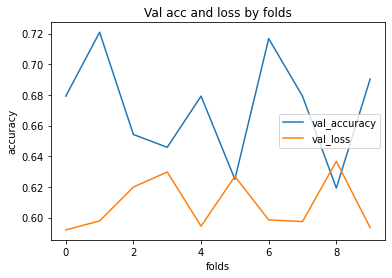

In [77]:
plt.plot(VALIDATION_ACCURACY, label = 'val_accuracy')
plt.plot(VALIDATION_LOSS, label = 'val_loss')

plt.legend(loc = 'right')
plt.xlabel('folds')
plt.ylabel('accuracy')
plt.title('Val acc and loss by folds')
plt.show()

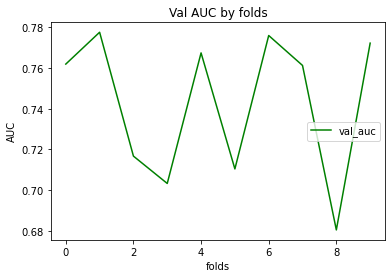

In [78]:
# auc

plt.plot(VALIDATION_AUC, label = 'val_auc', color = 'g')

plt.legend(loc = 'right')
plt.xlabel('folds')
plt.ylabel('AUC')
plt.title('Val AUC by folds')
plt.show()

In [79]:
# # roc curve - check if works

# from sklearn import datasets
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# X, y = X[y != 2], y[y != 2]
# n_samples, n_features = X.shape

# # Add noisy features
# random_state = np.random.RandomState(0)
# X = np.c_[X, random_state.randn(n_samples, 200*n_features)]

In [80]:
# import matplotlib.pyplot as plt
# from sklearn.model_selection import StratifiedKFold

# from sklearn import svm
# from sklearn.metrics import auc
# from sklearn.metrics import RocCurveDisplay

# # Run classifier with cross-validation and plot ROC curves
# cv = StratifiedKFold(n_splits = 6)
# classifier = svm.SVC(kernel = "linear", probability = True, random_state = random_state)

# tprs = []
# aucs = []
# mean_fpr = np.linspace(0, 1, 100)

# fig, ax = plt.subplots()
# for i, (train, test) in enumerate(cv.split(X, y)): 
#     viz = RocCurveDisplay.from_estimator(
#     model, 
#     train_data_generator, 
#     valid_data_generator, 
#     name = "ROC fold {}".format(fold_var), 
#     alpha = 0.3, 
#     lw = 1, 
#     ax = ax
# )

In [81]:
# # roc curve

# acc = history_res101.history['accuracy']
# val_acc = history_res101.history['val_accuracy']

# AUC = history_res101.history['AUC']
# val_AUC = history_res101.history['val_auc']

# epochs = range(1, len(acc) + 1)

# plt.plot(epochs, AUC, 'g', label = 'AUC')
# plt.plot(epochs, val_AUC, 'b', label = 'Val_AUC')
# plt.xlabel('No.of epochs')
# plt.ylabel('AUC')
# plt.title('Training and validation AUC')
# plt.legend()
# plt.figure()

In [ ]:
# PRE
# 다시 라벨별 분리하지 않은 데이터 경로에서 작업 (덕선선생님이 만드신것)
# test dataset 은 다시 라벨별로 분리해둔 폴더를 사용
# 1007 learning rate reduction 추가
from tensorflow.keras.callbacks import ReduceLROnPlateau

BATCH_SIZE = 32

ART_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/ART/'
PRE_train_path = '/home/ncp/workspace/blocks1/kidneyData_windowing_mass/TRAIN/PRE/'
ART_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/ART/'
PRE_test_path = '/home/ncp/workspace/blocks3/kidneyData_windowing_mass_classified/TEST/PRE/'

# y is imbalance - KFold 대신 StratifiedKFold 사용
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)

# create datagen
create_datagen = ImageDataGenerator(rescale= 1./255.)


# generate test data first
PRE_test_generator = create_datagen.flow_from_directory(PRE_test_path,
                                                   batch_size = BATCH_SIZE,
                                                   target_size = (512, 512),
                                                   class_mode = 'categorical')


## PERFORM TRAIN & VAL ## - ART

VALIDATION_ACCURACY_PRE = []
VALIDATION_LOSS_PRE = []
VALIDATION_AUC_PRE = []
val_acc_PRE = 0

fold_var = 1 # weight 나 모델 저장용

for train_index, val_index in skf.split(PRE_train_df, PRE_train_df['label']):  # Y의 분포 기준으로 나눔
    
    training_data = PRE_train_df.iloc[train_index]
    validation_data = PRE_train_df.iloc[val_index]
    
    train_data_generator = create_datagen.flow_from_dataframe(training_data, directory = PRE_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    valid_data_generator = create_datagen.flow_from_dataframe(validation_data, directory = PRE_train_path, 
                                                             x_col = 'filename', y_col = 'label', 
                                                             class_mode = 'categorical', 
                                                             shuffle = True)
    
    optimizer = optimizers.Adam(learning_rate= 0.0001, decay= 1e-6)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                           patience =3, 
                                           verbose =1,
                                            factor = 0.2,
                                            min_lr =0.0000001)
    model.compile(optimizer=optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy', 'AUC'])
    checkpointer = ModelCheckpoint(filepath='./2D_classification_PRE-ResNet101_crossval.hdf5',
                            monitor='val_loss', verbose = 1,
                            save_best_only=True)
    early_stopping = EarlyStopping(verbose=1, patience=15)

    history_res101_PRE = model.fit(train_data_generator,
                        steps_per_epoch = 20,
                        epochs = 100,
                        verbose = 1,
                        validation_data = valid_data_generator,
                        callbacks = [checkpointer,learning_rate_reduction])
    
    # validation accuracy, loss
    results_PRE = model.evaluate(valid_data_generator)
    results_PRE = dict(zip(model.metrics_names, results_PRE))
    
    VALIDATION_ACCURACY_PRE.append(results_PRE['accuracy'])
    VALIDATION_LOSS_PRE.append(results_PRE['loss'])
    VALIDATION_AUC_PRE.append(results_PRE['val_auc'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1
    
    val_acc_PRE += results_PRE['accuracy'] / 10   # 평균 ACC
    
print("mean validation accuracy: ", val_acc_PRE)

In [ ]:
result = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(VALIDATION_ACCURACY_PRE, label = 'val_accuracy',)
plt.plot(VALIDATION_LOSS_PRE, label = 'val_loss')

plt.legend(loc = 'right')
plt.xlabel('folds')
plt.ylabel('accuracy')
plt.title('Val acc and loss by folds')
plt.show()

In [ ]:
# auc

plt.plot(VALIDATION_AUC_PRE, label = 'val_auc', color = 'g')

plt.legend(loc = 'right')
plt.xlabel('folds')
plt.ylabel('AUC')
plt.title('Val AUC by folds')
plt.show()

In [ ]:
path_resnet_PRE = '/home/ncp/workspace/blocks3/zio_code/cancer_configuration_PRE-ResNet101_crossval.hdf5'
PRE_resnet = tf.keras.models.load_model(path_resnet_PRE)

In [ ]:
PRE_resnet()

In [ ]:
result_PRE = model.evaluate(PRE_test_generator)

In [ ]:
plt.plot(history_res101_PRE.history['accuracy'], label = 'train',)
plt.plot(history_res101_PRE.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [ ]:
!nvidia-smi